# Импорт библиотек

In [ ]:
!pip install --upgrade pip
!pip install sentencepiece datasets
! pip install -U accelerate
! pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [ ]:
import pandas as pd
import numpy as np
import string, re
from collections import Counter

from gspread import authorize
import pandas as pd

from oauth2client.service_account import ServiceAccountCredentials

scopes = ["https://spreadsheets.google.com/feeds",
                  "https://www.googleapis.com/auth/spreadsheets",
                  "https://www.googleapis.com/auth/drive",
                  "https://www.googleapis.com/auth/drive"]


In [ ]:
from typing import List
import numpy as np
import pandas as pd
import warnings
import logging
import os
import shutil
import json
import transformers
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
from sklearn.metrics import mean_squared_error
import torch
from sklearn.model_selection import KFold, GroupKFold
from tqdm import tqdm

from datasets import Dataset
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
import spacy
import re

import lightgbm as lgb


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

tqdm.pandas()

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define a class for configuration settings
class CFG:
    model_name = "WizardLM/WizardLM-70B-V1.0"  # Model name for reference
    learning_rate = 0.000016 # Learning rate
    weight_decay = 0.03  # Weight decay (L2 regularization)
    hidden_dropout_prob = 0.007  # Dropout probability for hidden layers
    attention_probs_dropout_prob = 0.007  # Dropout probability for attention layers
    num_train_epochs = 6  # Number of training epochs
    n_splits = 4  # Number of splits for cross-validation
    batch_size = 16  # Batch size for training data
    random_seed = 42  # Random seed for reproducibility
    save_steps = 50  # Number of steps before saving model checkpoints
    max_length = 512  # Maximum sequence length for input data

TARGET = "Solving a communicative task"

In [ ]:
def display_confusion_matrix(y_true, y_pred, model_name: str) -> None:

  confusion_matrix_data = confusion_matrix(y_true, y_pred)

  plt.figure(figsize=(8,8))
  cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_data, display_labels=sorted(y_true.unique()))
  cm_display.plot()
  plt.title(model_name)
  plt.show()

def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed=42)

# Чтение и очистка данных

In [ ]:
def read_from_gsheet():
    cred = ServiceAccountCredentials.from_json_keyfile_name('/content/drive/MyDrive/movs_project/credentials_googlesheets.json', scopes)
    gc = authorize(cred)
    sheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1m0mc1H7ULIZ2HEkT4dha_XRmRjt0gWJ8aht_GJ2lxfw/edit#gid=0')
    ws = sheet.worksheet('Dataset')
    return pd.DataFrame(ws.get_all_records())

def drop_unwanted_data(df: pd.DataFrame):
    columns_to_drop = ['Comments', 'origin', 'task_image', 'score_image']
    columns = ['Solving a communicative task', 'Text structure', 'Use of English (for emails)', 'Lexis (essay)',
               'Grammatical accuracy (essay)', 'Punctuation and spelling (essay)']

    # Удаляем лишние столбцы (на данный момент)
    df = df.drop(columns=columns_to_drop)

    # Удаляем строки баллов, если там сожержатся другие значения, кроме int и float (избавимся от string)
    for column in columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')

    return df

def split_types(df: pd.DataFrame):
    # Следующий этап - разделим на письма и эссе
    essay_df = df[df[' Type'] == 'Essay']
    email_df = df[df[' Type'] == 'Email']

    # и удалим лишние колонки для каждого типа
    essay_df = essay_df.drop(columns='Use of English (for emails)')
    email_df = email_df.drop(
        columns=['Lexis (essay)', 'Grammatical accuracy (essay)', 'Punctuation and spelling (essay)'])

    # Убираем NaN
    essay_df = essay_df.dropna()
    email_df = email_df.dropna()

    return essay_df, email_df


In [ ]:
# Читаем данные из таблицы, удаляем неинтересующие столбцы, фильтруем по типу задания
raw_data = read_from_gsheet()
_, email_data = split_types(raw_data)

## Добавление сгенерированных данных

In [ ]:
def read_new_data(path: str, columns: list, assigned_score: int, origin: str = "gpt") -> pd.DataFrame:
  new_data = pd.read_excel(path)

  if "Unnamed: 0" in new_data.columns:
    new_data = new_data.drop("Unnamed: 0", axis=1)

  new_data.columns = columns
  new_data["Solving a communicative task"] = assigned_score
  new_data["origin"] = origin

  if "Text" in new_data.columns:
    new_data = new_data.drop("Text", axis=1).rename(columns={"GPT_Text":"Text"})
  if "GPT_Question" in new_data.columns:
    new_data = new_data.drop("GPT_Question", axis=1)

  new_data["Text"] = new_data["Text"].replace({"\s+Explanation?([\s\S]*)": "", "\s+\---?([\s\S]*)": ""}, regex=True)

  return new_data

In [ ]:
gpt_data_wrong_questions = read_new_data("/content/drive/MyDrive/movs_project/data/263_emails_paraphrased.xlsx",
                                        ["Question", "Text", "GPT_Text"], 1, origin="gpt_wrong_questions")
gpt_data_wrong_answers = read_new_data("/content/drive/MyDrive/movs_project/data/263_emails_wrong_answers.xlsx",
                                        ["Question", "Text", "GPT_Question", "GPT_Text"], 0, origin="gpt_wrong_answers")

In [ ]:
email_data = pd.concat([gpt_data_wrong_questions, gpt_data_wrong_answers, email_data], ignore_index=True, axis=0)

## Question preprocessing

In [ ]:
def get_main_section(s):
  text = re.search(r"Subject:([\s\S]*?)Write an? e-?mail", str(s))
  if text is not None:
    return text.group(1)
  else:
    return None

def rm_after_write_phrase(s):
  text = re.sub(r"Write an? e-?mail[\s\S]*", "", str(s))
  return text

def get_after_newline(s):
  text = re.search("\n[\s\S]*", s)
  if text is not None:
    return text.group()
  else:
    print(s)
    return None

# def rm_dots(s):
#   text = re.sub(r"\.{2,}|…", "", s)
#   return text

def trim_questions(raw: pd.Series) -> pd.Series:
  full_questions = raw[raw.str.contains('You have received an email message', na=False)]
  trimmed_questions = full_questions.apply(get_main_section)
  trimmed_questions = trimmed_questions.str.replace("\n+", "\n", regex=True).str.strip()
  trimmed_questions = trimmed_questions.apply(get_after_newline)
  return trimmed_questions

In [ ]:
# Создадим новую колонку с уникальным индексом для вопросов
email_data["Question_id"] = email_data["Question"]

# Обрежем условия заданий, оставив только часть с вопросами и предложение для ответа на вопрос
trimmed_questions = trim_questions(email_data["Question"])
email_data.loc[trimmed_questions.index, "Question_id"] = trimmed_questions

In [ ]:
# Очистим ненужные символы и преобразуем к строчному регистру
initial_questions_indx = email_data.index.difference(trimmed_questions.index)
email_data.loc[initial_questions_indx, "Question_id"] = email_data.loc[initial_questions_indx, "Question"].apply(rm_after_write_phrase)
email_data["Question_id"] = email_data["Question_id"].str.replace("[^A-Za-z]", " ", regex=True).apply(lambda x: " ".join(x.split())).str.lower().str.strip()
email_data["Question_id"] = pd.factorize(email_data["Question_id"])[0]

## Фильтрация датасета

In [ ]:
email_data = email_data[email_data['Text'].str.strip().astype(bool)] # Удалим строки с пустыми ответами
email_data = email_data[~email_data['Question'].str.contains('[А-Яа-я]+', regex=True)]
email_data = email_data[email_data['Question'].notna()]
email_data = email_data[email_data['Question'] != '']
email_data["Text"] = email_data["Text"].apply(lambda x: re.sub(r'[^A-Za-z\s]', ' ', str(x)))

In [ ]:
score_columns = ['Solving a communicative task']
for score_col in score_columns:
    email_data = email_data[pd.to_numeric(email_data[score_col], errors='coerce').notna()]
    email_data[score_col] = email_data[score_col].astype(float)

<ipython-input-18-85e8b468c06b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  email_data[score_col] = email_data[score_col].astype(float)


In [ ]:
email_data["Solving a communicative task"].value_counts()

2.0    343
1.0    333
0.0    265
Name: Solving a communicative task, dtype: int64

In [ ]:
email_data["Question_id"].value_counts()[:10]

70    111
63     87
73     83
71     80
72     73
74     16
79     14
78     12
77     12
76     12
Name: Question_id, dtype: int64

In [ ]:
email_data[email_data["Question_id"] == 73]

,Question,Text,Solving a communicative task,origin,Type,Question id,Text structure,Use of English (for emails),Comments,Overall_score,task_image,score_image,Question_id
116,You have received an email message from your E...,Dear Andy \n\nI wanted to express my gratitude...,1.0,gpt_wrong_questions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73
117,You have received an email message from your E...,Dear Andy \n\nI wanted to express my appreciat...,1.0,gpt_wrong_questions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73
118,You have received an email message from your E...,Dear Andy \n\nThank you for your recent email ...,1.0,gpt_wrong_questions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73
119,You have received an email message from your E...,Dear Andy \n\nI want to express my gratitude f...,1.0,gpt_wrong_questions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73
120,You have received an email message from your E...,Dear Andy \n\nThank you for your recent email ...,1.0,gpt_wrong_questions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...
680,You have received an email message from your E...,Dear Andy \n \n Thanks for your recent email ...,2.0,https://nezagorami-eng.cloudtext.ru/works/1066,Email,,2,2,,6,,,73
681,You have received an email message from your E...,Dear Andy \n \n Thank you for your recent emai...,1.0,https://nezagorami-eng.cloudtext.ru/works/1064,Email,,1,1,,3,,,73
682,You have received an email message from your E...,Dear Andy \n \n Thanks for your recent email ...,1.0,https://nezagorami-eng.cloudtext.ru/works/1060,Email,,2,2,,5,,,73
683,You have received an email message from your E...,Dear Andy \n \n \n \n Thanks for your recent e...,2.0,https://nezagorami-eng.cloudtext.ru/works/1053,Email,,2,2,,6,,,73


In [ ]:
train = email_data.reset_index(drop=True)

## Group K-Fold

In [ ]:
# Create a GroupKFold object with the specified number of splits
gkf = GroupKFold(n_splits=CFG.n_splits)
groups = train["Question_id"]
# Iterate through the splits and assign fold numbers to validation data
for i, (_, val_index) in enumerate(gkf.split(train, groups=groups)):
    train.loc[val_index, "fold"] = i

# Display the first few rows of the training data with fold assignments
train.head()

,Question,Text,Solving a communicative task,origin,Type,Question id,Text structure,Use of English (for emails),Comments,Overall_score,task_image,score_image,Question_id,fold
0,...In Great Britain young people want to becom...,Hey Tom \n\nThanks for your message It was re...,1.0,gpt_wrong_questions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
1,... Summer is coming and I want to look my bes...,Dear Mary \n\nThank you for your message and ...,1.0,gpt_wrong_questions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
2,... My Mum often complains that I spend too mu...,Dear Andrea \n\nThank you for your message an...,1.0,gpt_wrong_questions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0.0
3,...Summer is coming and I want to look my best...,Dear Mary \n\nThank you for your message and ...,1.0,gpt_wrong_questions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
4,...I’m currently studying for my exams and hop...,Dear Richard \n\nThank you for your message a...,1.0,gpt_wrong_questions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1.0


## Stratified Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(email_data[["Question", "Text"]].values, email_data[TARGET].values,
    test_size=0.1,
    shuffle=True,
    stratify=email_data[TARGET].values,
    random_state=42
)

In [ ]:
train_data = pd.concat([pd.DataFrame(X_train, columns=["Question", "Text"]), pd.DataFrame(y_train, columns=[TARGET])], axis=1)
valid_data = pd.concat([pd.DataFrame(X_val, columns=["Question", "Text"]), pd.DataFrame(y_val, columns=[TARGET])], axis=1)

## Train / Test Split

In [ ]:
real_data = email_data[~email_data["origin"].str.contains("gpt")]

n_questions = 1
n_samples = 1
question_id_value_counts = real_data['Question_id'].value_counts()
questions_greater_than_n = question_id_value_counts[question_id_value_counts > n_questions].index.tolist()
test_pool = real_data[real_data['Question_id'].isin(questions_greater_than_n)]
test_pool = test_pool[test_pool[TARGET] != 0] # Удалим все письма с нелувым баллом, чтобы не было пересечений далее

test_samples = []
for question_id in test_pool["Question_id"].unique():
  candidates = test_pool[test_pool["Question_id"] == question_id]
  test_samples.append(candidates.sample(n=n_samples, random_state=42))

test_samples.append(real_data[real_data[TARGET] == 0]) # Возьмем в тестовую выборку все письма с нулевым баллом
test_data = pd.concat(test_samples, axis=0)

test_data.shape

(29, 13)

In [ ]:
train_index = email_data.index.difference(test_data.index)
train_data = email_data.loc[train_index, :]
train_data.shape

(912, 13)

In [ ]:
# Define a function to compute root mean squared error (RMSE)
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Calculate RMSE
    rmse = mean_squared_error(labels, predictions, squared=False)

    # Return RMSE as a dictionary
    return {"rmse": rmse}

# Создание класса модели и обучение

In [ ]:


# Define a class for the Content Score Regressor
class ContentScoreRegressor:
    def __init__(self,
                model_name: str,
                model_dir: str,
                target: str,
                hidden_dropout_prob: float,
                attention_probs_dropout_prob: float,
                max_length: int,
                ):
        # Define input columns and target column
        self.inputs = ["Question", "Text"]
        self.input_col = "input"
        self.text_cols = [self.input_col]
        self.target = target
        self.target_cols = [target]

        # Initialize model-related attributes
        self.model_name = model_name
        self.model_dir = model_dir
        self.max_length = max_length

        # Initialize tokenizer and model configuration
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model_config = AutoConfig.from_pretrained(model_name)

        # Update model configuration with additional parameters
        self.model_config.update({
            "hidden_dropout_prob": hidden_dropout_prob,
            "attention_probs_dropout_prob": attention_probs_dropout_prob,
            "num_labels": 1,
            "problem_type": "regression",
        })

        # Set a fixed random seed for reproducibility
        seed_everything(seed=42)

        # Initialize data collator for padding
        self.data_collator = DataCollatorWithPadding(
            tokenizer=self.tokenizer
        )

    def tokenize_function(self, examples: pd.DataFrame):
        labels = [examples[self.target]]
        tokenized = self.tokenizer(examples[self.input_col],
                         padding=True,
                         truncation=True,
                         max_length=self.max_length)
        return {
            **tokenized,
            "labels": labels,
        }

    def tokenize_function_test(self, examples: pd.DataFrame):
        tokenized = self.tokenizer(examples[self.input_col],
                         padding=False,
                         truncation=True,
                         max_length=self.max_length)
        return tokenized

    def train(self,
            fold: int,
            train_df: pd.DataFrame,
            valid_df: pd.DataFrame,
            batch_size: int,
            learning_rate: float,
            weight_decay: float,
            num_train_epochs: float,
            save_steps: int,
        ) -> None:
        """Fine-tuning the model"""

        sep = self.tokenizer.sep_token

        # Create input text by concatenating title, question, and summary
        train_df[self.input_col] = (
                    train_df["Question"] + sep
                    + train_df["Text"]
                  )

        valid_df[self.input_col] = (
                    valid_df["Question"] + sep
                    + valid_df["Text"]
                  )

        # Select relevant columns for training and validation
        train_df = train_df[[self.input_col] + self.target_cols]
        valid_df = valid_df[[self.input_col] + self.target_cols]

        # Load the pre-trained model for content score prediction
        model_content = AutoModelForSequenceClassification.from_pretrained(
            self.model_name,
            config=self.model_config
        )

        # Create datasets from DataFrames
        train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
        val_dataset = Dataset.from_pandas(valid_df, preserve_index=False)

        # Tokenize and preprocess the datasets
        train_tokenized_datasets = train_dataset.map(self.tokenize_function, batched=False)
        val_tokenized_datasets = val_dataset.map(self.tokenize_function, batched=False)

        # Define model training arguments
        model_fold_dir = os.path.join(self.model_dir, str(fold))
        training_args = TrainingArguments(
            output_dir=model_fold_dir,
            load_best_model_at_end=True,
            learning_rate=learning_rate,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=8,
            num_train_epochs=num_train_epochs,
            weight_decay=weight_decay,
            report_to='none',
            greater_is_better=False,
            save_strategy="steps",
            evaluation_strategy="steps",
            eval_steps=save_steps,
            save_steps=save_steps,
            metric_for_best_model="rmse",
            save_total_limit=1
        )

        # Create a trainer for model training
        trainer = Trainer(
            model=model_content,
            args=training_args,
            train_dataset=train_tokenized_datasets,
            eval_dataset=val_tokenized_datasets,
            tokenizer=self.tokenizer,
            compute_metrics=compute_metrics,
            data_collator=self.data_collator
        )

        # Train the model
        trainer.train()

        # Save the trained model and tokenizer
        model_content.save_pretrained(self.model_dir)
        self.tokenizer.save_pretrained(self.model_dir)


    def predict(self,
                test_df: pd.DataFrame,
                fold: int,
               ):
        """Predict content score for test data"""

        sep = self.tokenizer.sep_token

        # Create input text for test data
        in_text = (
                    test_df["Question"] + sep
                    + test_df["Text"]
                  )
        test_df[self.input_col] = in_text

        # Select the relevant columns
        test_ = test_df[[self.input_col]]

        # Create a dataset from the test data
        test_dataset = Dataset.from_pandas(test_, preserve_index=False)
        test_tokenized_dataset = test_dataset.map(self.tokenize_function_test, batched=False)

        # Load the trained content score prediction model
        model_content = AutoModelForSequenceClassification.from_pretrained(self.model_dir)
        model_content.eval()

        # Define model prediction arguments
        model_fold_dir = os.path.join(self.model_dir, str(fold))
        test_args = TrainingArguments(
            output_dir=model_fold_dir,
            do_train = False,
            do_predict = True,
            per_device_eval_batch_size = 4,
            dataloader_drop_last = False,
        )

        # Initialize a trainer for inference
        infer_content = Trainer(
                      model = model_content,
                      tokenizer=self.tokenizer,
                      data_collator=self.data_collator,
                      args = test_args)

        # Perform predictions
        preds = infer_content.predict(test_tokenized_dataset)[0]

        return preds



In [ ]:
# Define a function for training by fold
def train_by_fold(
        train_df: pd.DataFrame,
        model_name: str,
        target: str,
        save_each_model: bool,
        n_splits: int,
        batch_size: int,
        learning_rate: int,
        hidden_dropout_prob: float,
        attention_probs_dropout_prob: float,
        weight_decay: float,
        num_train_epochs: int,
        save_steps: int,
        max_length: int
    ):

    model_basename = os.path.basename(model_name)

    # Delete old model files
    if os.path.exists(f"train_{model_basename}"):
        shutil.rmtree(f"train_{model_basename}")

    os.mkdir(f"train_{model_basename}")

    for fold in range(n_splits):
        print(f"fold {fold}:")

        train_data = train_df[train_df["fold"] != fold]
        valid_data = train_df[train_df["fold"] == fold]

        if save_each_model == True:
            model_dir =  f"{target}/{model_basename}/fold_{fold}"
        else:
            model_dir =  f"train_{model_basename}/fold_{fold}"

        csr = ContentScoreRegressor(
            model_name=model_name,
            target=target,
            model_dir=model_dir,
            hidden_dropout_prob=hidden_dropout_prob,
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            max_length=max_length,
        )

        csr.train(
            fold=fold,
            train_df=train_data,
            valid_df=valid_data,
            batch_size=batch_size,
            learning_rate=learning_rate,
            weight_decay=weight_decay,
            num_train_epochs=num_train_epochs,
            save_steps=save_steps,
        )

def train_by_stratified_split(
        train_data: pd.DataFrame,
        valid_data: pd.DataFrame,
        model_name: str,
        target: str,
        save_each_model: bool,
        n_splits: int,
        batch_size: int,
        learning_rate: int,
        hidden_dropout_prob: float,
        attention_probs_dropout_prob: float,
        weight_decay: float,
        num_train_epochs: int,
        save_steps: int,
        max_length: int
):

    model_basename = os.path.basename(model_name)

    # Delete old model files
    if os.path.exists(f"train_{model_basename}"):
        shutil.rmtree(f"train_{model_basename}")

    os.mkdir(f"train_{model_basename}")

    if save_each_model == True:
        model_dir =  f"{target}/{model_basename}/stratified"
    else:
        model_dir =  f"train_{model_basename}/stratified"

    csr = ContentScoreRegressor(
        model_name=model_name,
        target=target,
        model_dir=model_dir,
        hidden_dropout_prob=hidden_dropout_prob,
        attention_probs_dropout_prob=attention_probs_dropout_prob,
        max_length=max_length,
    )

    csr.train(
        fold="stratified",
        train_df=train_data,
        valid_df=valid_data,
        batch_size=batch_size,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        num_train_epochs=num_train_epochs,
        save_steps=save_steps,
    )

    return csr


# Define a function for validation (predicting oof data)
def validate(
    train_df: pd.DataFrame,
    target: str,
    save_each_model: bool,
    model_name: str,
    hidden_dropout_prob: float,
    attention_probs_dropout_prob: float,
    max_length: int
    ) -> pd.DataFrame:
    """Predict out-of-fold (oof) data"""
    model_basename = os.path.basename(model_name)

    for fold in range(CFG.n_splits):
        print(f"fold {fold}:")

        valid_data = train_df[train_df["fold"] == fold]

        if save_each_model == True:
            model_dir =  f"{target}/{model_basename}/fold_{fold}"
        else:
            model_dir =  f"train_{model_basename}/fold_{fold}"

        csr = ContentScoreRegressor(
            model_name=model_name,
            target=target,
            model_dir=model_dir,
            hidden_dropout_prob=hidden_dropout_prob,
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            max_length=max_length,
        )

        pred = csr.predict(
            test_df=valid_data,
            fold=fold
        )

        train_df.loc[valid_data.index, f"{target}_pred"] = pred

    return train_df

def validate_stratified(
    valid_data: pd.DataFrame,
    target: str,
    save_each_model: bool,
    model_name: str,
    hidden_dropout_prob: float,
    attention_probs_dropout_prob: float,
    max_length: int
    ) -> pd.DataFrame:
    """Predict vaidation data"""
    model_basename = os.path.basename(model_name)
    val_data = valid_data.copy()

    if save_each_model == True:
        model_dir =  f"{target}/{model_basename}/stratified"
    else:
        model_dir =  f"train_{model_basename}/stratified"

    csr = ContentScoreRegressor(
        model_name=model_name,
        target=target,
        model_dir=model_dir,
        hidden_dropout_prob=hidden_dropout_prob,
        attention_probs_dropout_prob=attention_probs_dropout_prob,
        max_length=max_length,
    )

    pred = csr.predict(
        test_df=val_data,
        fold="stratified"
    )

    val_data.loc[val_data.index, f"{target}_pred"] = pred

    return val_data

# Define a function for prediction (using mean folds)
def predict(
    test_df: pd.DataFrame,
    target: str,
    save_each_model: bool,
    model_name: str,
    hidden_dropout_prob: float,
    attention_probs_dropout_prob: float,
    max_length: int
    ):
    """Predict using mean of folds"""
    model_basename = os.path.basename(model_name)

    for fold in range(CFG.n_splits):
        print(f"fold {fold}:")

        if save_each_model == True:
            model_dir =  f"{target}/{model_basename}/fold_{fold}"
        else:
            model_dir =  f"train_{model_basename}/fold_{fold}"

        csr = ContentScoreRegressor(
            model_name=model_name,
            target=target,
            model_dir=model_dir,
            hidden_dropout_prob=hidden_dropout_prob,
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            max_length=max_length,
        )

        pred = csr.predict(
            test_df=test_df,
            fold=fold
        )

        test_df[f"{target}_pred_{fold}"] = pred



    test_df[f"{target}"] = test_df[[f"{target}_pred_{fold}" for fold in range(CFG.n_splits)]].mean(axis=1)

    return test_df

In [ ]:
def start_training_by_fold(train, model_name) -> None:
  CFG.model_name = model_name

  for target in ["Solving a communicative task"]:

      train_by_fold(
          train,
          model_name=CFG.model_name,
          save_each_model=False,
          target=target,
          learning_rate=CFG.learning_rate,
          hidden_dropout_prob=CFG.hidden_dropout_prob,
          attention_probs_dropout_prob=CFG.attention_probs_dropout_prob,
          weight_decay=CFG.weight_decay,
          num_train_epochs=CFG.num_train_epochs,
          n_splits=CFG.n_splits,
          batch_size=CFG.batch_size,
          save_steps=CFG.save_steps,
          max_length=CFG.max_length
      )


      pred_data = validate(
          train,
          target=target,
          save_each_model=False,
          model_name=CFG.model_name,
          hidden_dropout_prob=CFG.hidden_dropout_prob,
          attention_probs_dropout_prob=CFG.attention_probs_dropout_prob,
          max_length=CFG.max_length
      )

      rmse = mean_squared_error(pred_data[target], pred_data[f"{target}_pred"], squared=False)
      print('=========================== \n')
      print(f"cv {target} rmse: {rmse}")
      print('===========================')

      return pred_data

def start_training_by_stratified_split(train_data, valid_data, model_name) -> pd.DataFrame:
  CFG.model_name = model_name
  target = "Solving a communicative task"

  csr = train_by_stratified_split(
      train_data,
      valid_data,
      model_name=CFG.model_name,
      save_each_model=False,
      target=target,
      learning_rate=CFG.learning_rate,
      hidden_dropout_prob=CFG.hidden_dropout_prob,
      attention_probs_dropout_prob=CFG.attention_probs_dropout_prob,
      weight_decay=CFG.weight_decay,
      num_train_epochs=CFG.num_train_epochs,
      n_splits=CFG.n_splits,
      batch_size=CFG.batch_size,
      save_steps=CFG.save_steps,
      max_length=CFG.max_length
  )


  pred_data = validate_stratified(
      valid_data,
      target=target,
      save_each_model=False,
      model_name=CFG.model_name,
      hidden_dropout_prob=CFG.hidden_dropout_prob,
      attention_probs_dropout_prob=CFG.attention_probs_dropout_prob,
      max_length=CFG.max_length
  )

  return csr, pred_data

## bert-base-uncased

In [ ]:
pred_data = start_training_by_fold(train, "bert-base-uncased")

fold 0:


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

<ipython-input-167-38a8ead5b812>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[self.input_col] = (
<ipython-input-167-38a8ead5b812>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df[self.input_col] = (
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret 

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/705 [00:00<?, ? examples/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Rmse
50,No log,0.452404,0.672610
100,No log,0.327668,0.572423
150,No log,0.363938,0.603273
200,No log,0.279794,0.528955
250,No log,0.274733,0.524150


fold 1:


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
<ipython-input-167-38a8ead5b812>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[self.input_col] = (
<ipython-input-167-38a8ead5b812>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

Map:   0%|          | 0/706 [00:00<?, ? examples/s]

Map:   0%|          | 0/235 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Rmse
50,No log,0.393855,0.627579
100,No log,0.266005,0.515757
150,No log,0.224159,0.473454
200,No log,0.222655,0.471863
250,No log,0.216710,0.465522


fold 2:


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
<ipython-input-167-38a8ead5b812>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[self.input_col] = (
<ipython-input-167-38a8ead5b812>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

Map:   0%|          | 0/706 [00:00<?, ? examples/s]

Map:   0%|          | 0/235 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Rmse
50,No log,0.391007,0.625305
100,No log,0.264509,0.514304
150,No log,0.271551,0.521106
200,No log,0.249090,0.499089
250,No log,0.226626,0.476052


fold 3:


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
<ipython-input-167-38a8ead5b812>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[self.input_col] = (
<ipython-input-167-38a8ead5b812>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

Map:   0%|          | 0/706 [00:00<?, ? examples/s]

Map:   0%|          | 0/235 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Rmse
50,No log,0.311221,0.557872
100,No log,0.188665,0.434356
150,No log,0.215746,0.464484
200,No log,0.157852,0.397305
250,No log,0.154717,0.393341


fold 0:


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
<ipython-input-167-38a8ead5b812>:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[self.input_col] = in_text


Map:   0%|          | 0/236 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


fold 1:


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
<ipython-input-167-38a8ead5b812>:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[self.input_col] = in_text


Map:   0%|          | 0/235 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


fold 2:


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
<ipython-input-167-38a8ead5b812>:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[self.input_col] = in_text


Map:   0%|          | 0/235 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


fold 3:


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
<ipython-input-167-38a8ead5b812>:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[self.input_col] = in_text


Map:   0%|          | 0/235 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



cv Solving a communicative task rmse: 0.4671796265564022


<Figure size 800x800 with 0 Axes>

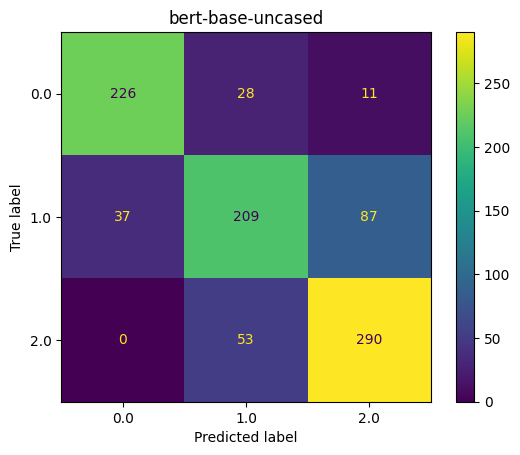

In [ ]:
display_confusion_matrix(train[TARGET], train[f"{TARGET}_pred"].apply(lambda x: round(x)), os.path.basename(CFG.model_name))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(train[TARGET], train[f"{TARGET}_pred"].apply(lambda x: round(x))))

              precision    recall  f1-score   support

         0.0       0.86      0.85      0.86       265
         1.0       0.72      0.63      0.67       333
         2.0       0.75      0.85      0.79       343

    accuracy                           0.77       941
   macro avg       0.78      0.78      0.77       941
weighted avg       0.77      0.77      0.77       941



In [ ]:
csr, pred_data = start_training_by_stratified_split(train_data, test_data, "bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/912 [00:00<?, ? examples/s]

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Rmse
50,No log,0.500554,0.707499
100,No log,0.559122,0.747744
150,No log,0.533958,0.730725
200,No log,0.579809,0.761452
250,No log,0.657241,0.810704
300,No log,0.653559,0.808430
350,No log,0.560612,0.748741
400,No log,0.625687,0.791004
450,No log,0.514086,0.716998
500,0.122600,0.542643,0.736643


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/29 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


<Figure size 800x800 with 0 Axes>

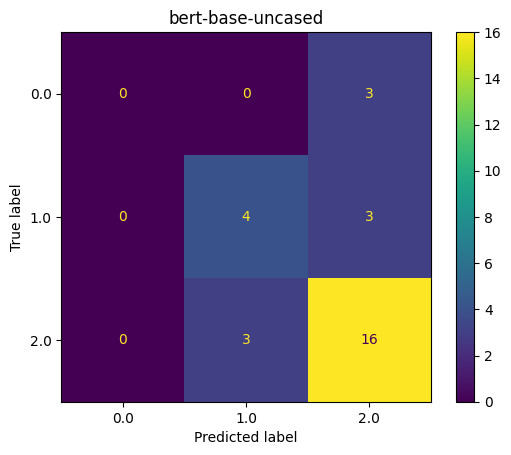

In [ ]:
display_confusion_matrix(pred_data[TARGET], pred_data[f"{TARGET}_pred"].apply(lambda x: round(x)), os.path.basename(CFG.model_name))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(pred_data[TARGET], pred_data[f"{TARGET}_pred"].apply(lambda x: round(x))))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.57      0.57      0.57         7
         2.0       0.73      0.84      0.78        19

    accuracy                           0.69        29
   macro avg       0.43      0.47      0.45        29
weighted avg       0.61      0.69      0.65        29



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
!cp -r /content/train_bert-base-uncased /content/drive/MyDrive/movs_project

## deberta-v3-base

In [ ]:
pred_data = start_training_by_fold(train, "microsoft/deberta-v3-base")

fold 0:


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
<ipython-input-167-38a8ead5b812>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[self.input_col] = (
<ipython-input-167-38a8ead5b812>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/705 [00:00<?, ? examples/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Rmse
50,No log,0.475843,0.689813
100,No log,0.452470,0.672659
150,No log,0.416743,0.645556
200,No log,0.299504,0.547269
250,No log,0.287326,0.536028


fold 1:


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.


Map:   0%|          | 0/706 [00:00<?, ? examples/s]

Map:   0%|          | 0/235 [00:00<?, ? examples/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Rmse
50,No log,0.363856,0.603205
100,No log,0.306880,0.553967
150,No log,0.183160,0.427972
200,No log,0.201799,0.449220
250,No log,0.181358,0.425862


fold 2:


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.


Map:   0%|          | 0/706 [00:00<?, ? examples/s]

Map:   0%|          | 0/235 [00:00<?, ? examples/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Rmse
50,No log,0.387791,0.622728
100,No log,0.331045,0.575365
150,No log,0.290394,0.538882
200,No log,0.270580,0.520173
250,No log,0.217735,0.466621


fold 3:


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.


Map:   0%|          | 0/706 [00:00<?, ? examples/s]

Map:   0%|          | 0/235 [00:00<?, ? examples/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Rmse
50,No log,0.334788,0.578609
100,No log,0.277396,0.526684
150,No log,0.177349,0.421128
200,No log,0.171894,0.414602
250,No log,0.147015,0.383425


fold 0:


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.


Map:   0%|          | 0/236 [00:00<?, ? examples/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


fold 1:


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.


Map:   0%|          | 0/235 [00:00<?, ? examples/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


fold 2:


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.


Map:   0%|          | 0/235 [00:00<?, ? examples/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


fold 3:


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.


Map:   0%|          | 0/235 [00:00<?, ? examples/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



cv Solving a communicative task rmse: 0.45655494726953766


<Figure size 800x800 with 0 Axes>

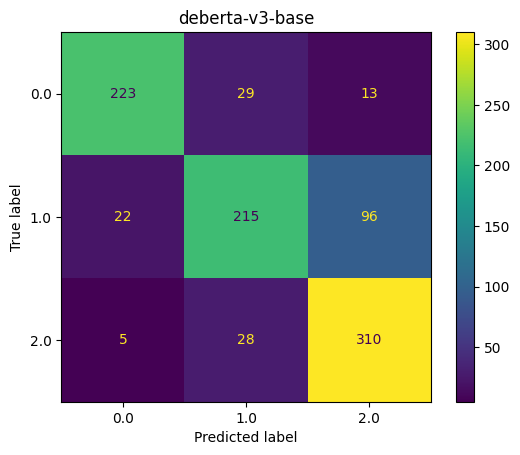

In [ ]:
display_confusion_matrix(train[TARGET], train[f"{TARGET}_pred"].apply(lambda x: round(x)), os.path.basename(CFG.model_name))

In [ ]:
pred_data = start_training_by_stratified_split(train_data, test_data, "microsoft/deberta-v3-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.


Map:   0%|          | 0/911 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Rmse
50,No log,0.520138,0.721206
100,No log,0.504112,0.710009
150,No log,0.598982,0.773939
200,No log,0.514866,0.717542
250,No log,0.571340,0.755871
300,No log,0.508545,0.713123
350,No log,0.521558,0.722190
400,No log,0.439664,0.663071
450,No log,0.576764,0.759450
500,0.199900,0.457937,0.676711


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.


Map:   0%|          | 0/30 [00:00<?, ? examples/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


<Figure size 800x800 with 0 Axes>

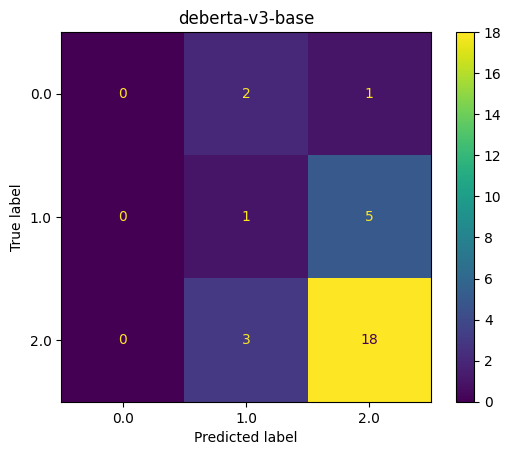

In [ ]:
display_confusion_matrix(pred_data[TARGET], pred_data[f"{TARGET}_pred"].apply(lambda x: round(x)), os.path.basename(CFG.model_name))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(pred_data[TARGET], pred_data[f"{TARGET}_pred"].apply(lambda x: round(x))))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.17      0.17      0.17         6
         2.0       0.75      0.86      0.80        21

    accuracy                           0.63        30
   macro avg       0.31      0.34      0.32        30
weighted avg       0.56      0.63      0.59        30



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Порядок обучения: реальные, сгенерированные данные

In [ ]:
real_train = train_data[~train_data["origin"].str.contains("gpt")]
synt_train = train_data[train_data["origin"].str.contains("gpt")]

In [ ]:
csr, pred_data = start_training_by_stratified_split(real_train, test_data, "microsoft/deberta-v3-base")

<Figure size 800x800 with 0 Axes>

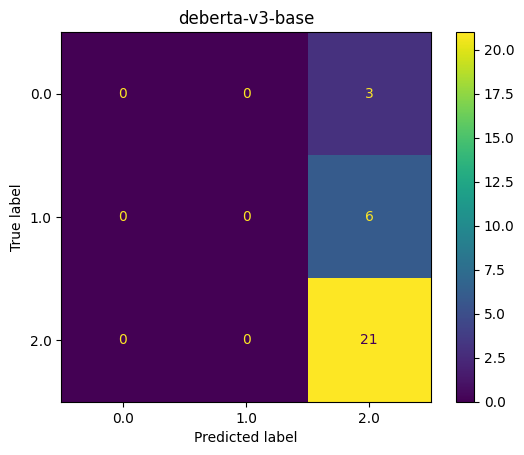

In [ ]:
display_confusion_matrix(pred_data[TARGET], pred_data[f"{TARGET}_pred"].apply(lambda x: round(x)), os.path.basename(CFG.model_name))

In [ ]:
csr.train(
    fold="stratified",
    train_df=real_train,
    valid_df=test_data,
    batch_size=CFG.batch_size,
    learning_rate=CFG.learning_rate,
    weight_decay=CFG.weight_decay,
    num_train_epochs=CFG.num_train_epochs,
    save_steps=CFG.save_steps,
)

<ipython-input-28-38a8ead5b812>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[self.input_col] = (
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/398 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Rmse
50,No log,0.630551,0.794072
100,No log,0.388859,0.623586
150,No log,0.481423,0.693847
200,No log,0.386388,0.621601


In [ ]:
pred_data = validate_stratified(test_data,
            TARGET,
            False,
            "microsoft/deberta-v3-base",
            CFG.hidden_dropout_prob,
            CFG.attention_probs_dropout_prob,
            CFG.max_length)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/30 [00:00<?, ? examples/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


<Figure size 800x800 with 0 Axes>

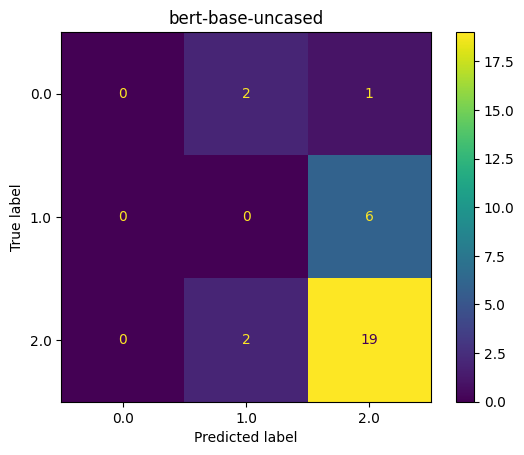

In [ ]:
display_confusion_matrix(pred_data[TARGET], pred_data[f"{TARGET}_pred"].apply(lambda x: round(x)), os.path.basename(CFG.model_name))

In [ ]:
pred_data[(pred_data[TARGET] == 0) & (pred_data[f"{TARGET}_pred"].apply(lambda x: round(x)) == 1)]

,Question,Text,Solving a communicative task,origin,Type,Question id,Text structure,Use of English (for emails),Comments,Overall_score,task_image,score_image,Question_id,input,Solving a communicative task_pred
520,…Our PE teacher is super! He lets us play diff...,Hi Dave \nGreat to hear from you Sorry that ...,0.0,ФИПИ,Email,,0,0,Подведём итог по критерию «Решение коммуникати...,,,,89,…Our PE teacher is super! He lets us play diff...,1.108630
668,You have received an email message from your E...,Dear Andy \n \n Thanks for your email I was ...,0.0,https://nezagorami-eng.cloudtext.ru/works/1100,Email,,0,0,,0,,,73,You have received an email message from your E...,1.453663


In [ ]:
pred_data[(pred_data[TARGET] == 2) & (pred_data[f"{TARGET}_pred"].apply(lambda x: round(x)) == 1)]

,Question,Text,Solving a communicative task,origin,Type,Question id,Text structure,Use of English (for emails),Comments,Overall_score,task_image,score_image,Question_id,input,Solving a communicative task_pred
953,... Today my family went to the supermarket an...,Dear Cathleen \n\nThanks for your letter I m ...,2.0,РЕШУ ЕГЭ,Email,https://en-ege.sdamgia.ru/problem?id=13074\n,2,2,,6,,,65,... Today my family went to the supermarket an...,1.368293
628,... Today my family went to the supermarket an...,Dear Cathleen \n\nThanks a ton for your recen...,2.0,Личный архив Максима,Email,Дамир Хайруллин стр13,2,1,"my fun holidays - это не твои fun holidays, а ...",5,,,106,... Today my family went to the supermarket an...,1.337257


In [ ]:
pred_data.loc[953, "Question"]

"... Today my family went to the supermarket and bought a huge bag of sweets and other treats to be ready for tomorrow's trick or-treaters, because tomorrow is Halloween! What fun holidays and festivals do you have in Russia? Which one of them is your favourite and why? How do you and your family spend it?\n\nBy the way, our pumpkin turned into a Jack-o-Lantern was voted the best in the neighbourhood!..."

In [ ]:
pred_data.loc[628, "Question"]

"... Today my family went to the supermarket and bought a huge bag of sweets and other treats to be ready for tomorrow's trick-or-treaters, because tomorrow is Halloween! What fun holidays and festivals do you have in Russia? Which one of them is your favourite and why? How do you and your family spend it?\r\nBy the way, our pumpkin turned into a Jack-o-Lantern was voted the best in the neighbourhood!..."

## albert-base-v2

In [ ]:
start_training(train, "albert-base-v2")

In [ ]:
display_confusion_matrix(train[TARGET], train[f"{TARGET}_pred"].apply(lambda x: round(x)), os.path.basename(CFG.model_name))

## distilbert-base-uncased

In [ ]:
csr, pred_data = start_training_by_stratified_split(real_train, test_data, "distilbert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

<ipython-input-107-0fbe82649aa1>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[self.input_col] = (
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/398 [00:00<?, ? examples/s]

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Rmse
50,No log,0.483923,0.695646
100,No log,0.407053,0.638007
150,No log,0.659896,0.812340
200,No log,0.536046,0.732152
250,No log,0.561058,0.749038
300,No log,0.561330,0.749219
350,No log,0.596750,0.772496
400,No log,0.520539,0.721484
450,No log,0.592371,0.769656
500,0.105200,0.548881,0.740865


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/29 [00:00<?, ? examples/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


<Figure size 800x800 with 0 Axes>

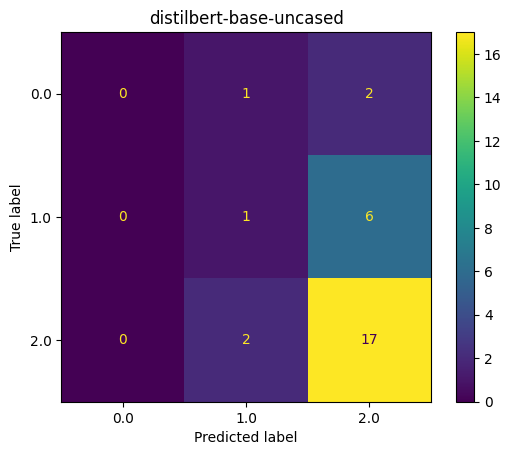

In [ ]:
display_confusion_matrix(pred_data[TARGET], pred_data[f"{TARGET}_pred"].apply(lambda x: round(x)), os.path.basename(CFG.model_name))